<a href="https://colab.research.google.com/github/krishalvian/Pancreatic-Mass-Segmentation/blob/main/Trial_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
image_train_path = "/content/drive/MyDrive/Skripsi/Final/Split/Images/Train"
image_test_path = "/content/drive/MyDrive/Skripsi/Final/Split/Images/Test"
mask_train_path = "/content/drive/MyDrive/Skripsi/Final/Split/Labels/Train"
mask_test_path = "/content/drive/MyDrive/Skripsi/Final/Split/Labels/Test"

train_images = sorted([os.path.join(image_train_path, fname) for fname in os.listdir(image_train_path)])
train_masks = sorted([os.path.join(mask_train_path, fname) for fname in os.listdir(mask_train_path)])
test_images = sorted([os.path.join(image_test_path, fname) for fname in os.listdir(image_test_path)])
test_masks = sorted([os.path.join(mask_test_path, fname) for fname in os.listdir(mask_test_path)])

In [4]:
class TumorSegmentationGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=4, shuffle=True, target_size=(480, 640)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.target_size = target_size
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        idxs = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images, batch_masks = [], []
        for i in idxs:
            img = cv2.imread(self.image_paths[i])
            img = cv2.resize(img, (self.target_size[1], self.target_size[0]))
            img = img / 255.0
            mask = cv2.imread(self.mask_paths[i], cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (self.target_size[1], self.target_size[0]))
            mask = (mask > 127).astype(np.uint8)[..., np.newaxis]
            batch_images.append(img)
            batch_masks.append(mask)
        return np.array(batch_images), np.array(batch_masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [5]:
def conv_block(x, filters, kernel_size=3, strides=1):
    x = layers.Conv2D(filters, kernel_size, padding='same', strides=strides)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def rpn_head(feature_map, anchors_per_location=9):
    shared = conv_block(feature_map, 256)
    objectness = layers.Conv2D(anchors_per_location, (1, 1))(shared)
    bbox_deltas = layers.Conv2D(anchors_per_location * 4, (1, 1))(shared)
    return objectness, bbox_deltas

def build_mask_rcnn(input_shape=(480, 640, 3), num_classes=1):
    input_image = layers.Input(shape=input_shape)

    # Backbone ResNet50
    backbone = tf.keras.applications.ResNet50(include_top=False, input_tensor=input_image)
    C5 = backbone.get_layer("conv5_block3_out").output
    C4 = backbone.get_layer("conv4_block6_out").output
    C3 = backbone.get_layer("conv3_block4_out").output

    # Feature Pyramid Network (FPN)
    P5 = conv_block(C5, 256, 1)
    P4 = layers.Add()([conv_block(C4, 256, 1), layers.UpSampling2D()(P5)])
    P3 = layers.Add()([conv_block(C3, 256, 1), layers.UpSampling2D()(P4)])

    # Region Proposal Network
    rpn_class_logits, rpn_bbox = rpn_head(P3)

    # ROIAlign (Simplified with UpSampling2D)
    x = layers.UpSampling2D(size=(2, 2))(P3)
    x = conv_block(x, 128)
    x = layers.UpSampling2D(size=(2, 2))(x)
    x = conv_block(x, 64)

    # Segmentation Head (Mask)
    x = conv_block(x, 64)

    # Add UpSampling to match the input size (480, 640)
    x = layers.UpSampling2D(size=(2, 2))(x)  # Upsample to 480x640
    x = layers.Conv2D(num_classes, (1, 1), activation="sigmoid")(x)  # Sigmoid for binary mask

    model = models.Model(inputs=input_image, outputs=x)
    return model

In [6]:
model = build_mask_rcnn()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

train_generator = TumorSegmentationGenerator(train_images, train_masks, batch_size=4)
test_generator = TumorSegmentationGenerator(test_images, test_masks, batch_size=4, shuffle=False)

model.fit(train_generator, validation_data=test_generator, epochs=20)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 2041s 6s/step - accuracy: 0.9430 - loss: 0.1633 - val_accuracy: 0.9520 - val_loss: 0.2588
Epoch 2/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 123s 360ms/step - accuracy: 0.9685 - loss: 0.0772 - val_accuracy: 0.9520 - val_loss: 0.3207
Epoch 3/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 122s 358ms/step - accuracy: 0.9761 - loss: 0.0590 - val_accuracy: 0.9663 - val_loss: 0.1198
Epoch 4/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 122s 357ms/step - accuracy: 0.9816 - loss: 0.0447 - val_accuracy: 0.9552 - val_loss: 0.1977
Epoch 5/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 122s 359ms/step - accuracy: 0.9854 - loss: 0.0354 - val_accuracy: 0.9783 - val_loss: 0.0565
Epoch 6/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 122s 358ms/step - accuracy: 0.9877 - loss: 0.0299 - val_accuracy: 0.9744 - val_loss: 0.0750
Epoch 7/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 122s 359ms/step - accuracy: 0.9883 - loss: 0.0285 - val_accuracy: 0.9860 - val_loss: 0.0397
Epoch 8/20
341/341 ━━━━━━━━━━━━━━━━━━━━ 122s 359ms/step - accuracy: 0.9927 - l

86/86 ━━━━━━━━━━━━━━━━━━━━ 19s 175ms/step


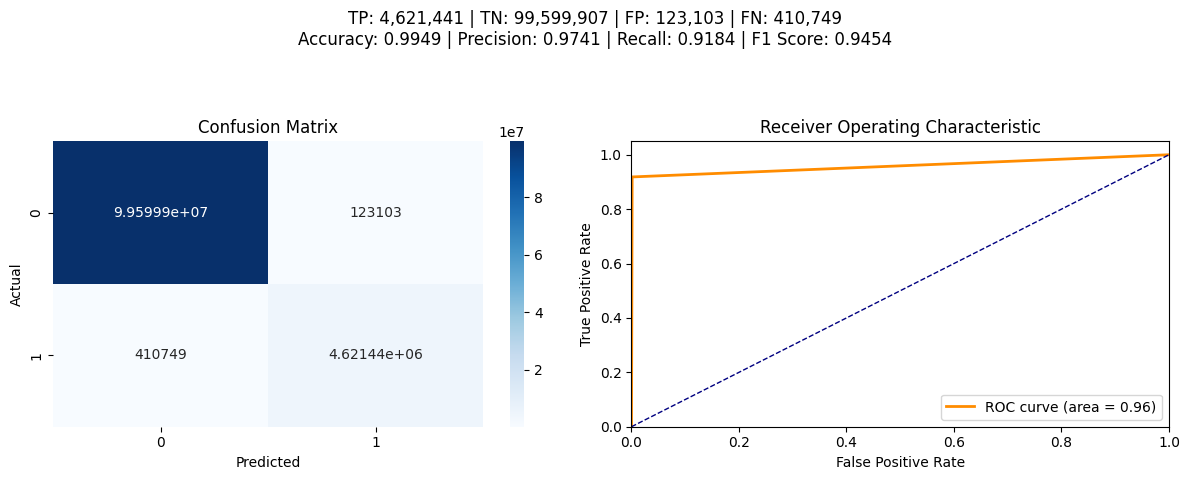

In [7]:
# Prediksi
preds = model.predict(test_generator)
preds = (preds > 0.5).astype(np.uint8)

all_gt = []
all_pred = []

for i in range(len(test_generator)):
    images, masks = test_generator[i]
    all_gt.append(masks)
    all_pred.append(preds[i * 4:(i + 1) * 4])  # batch_size=4

all_gt = np.concatenate(all_gt, axis=0)
all_pred = np.concatenate(all_pred, axis=0)

# Flatten
all_gt_flat = all_gt.flatten()
all_pred_flat = all_pred.flatten()

# Metrik
acc = accuracy_score(all_gt_flat, all_pred_flat)
prec = precision_score(all_gt_flat, all_pred_flat, zero_division=0)
rec = recall_score(all_gt_flat, all_pred_flat, zero_division=0)
f1 = f1_score(all_gt_flat, all_pred_flat, zero_division=0)
cm = confusion_matrix(all_gt_flat, all_pred_flat)

# Ekstrak TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()

# ROC
fpr, tpr, _ = roc_curve(all_gt_flat, all_pred_flat)
roc_auc = auc(fpr, tpr)

# Plot Confusion Matrix dan ROC Curve
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=axs[0])
axs[0].set_title('Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

# ROC Curve
axs[1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axs[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('Receiver Operating Characteristic')
axs[1].legend(loc="lower right")

# Tambahkan summary metrik dan TP/TN/FP/FN di judul atas
plt.suptitle(
    f"TP: {TP:,} | TN: {TN:,} | FP: {FP:,} | FN: {FN:,}\n"
    f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f}",
    fontsize=12
)

plt.tight_layout(rect=[0, 0.03, 1, 0.90])  # Supaya suptitle tidak terpotong
plt.show()

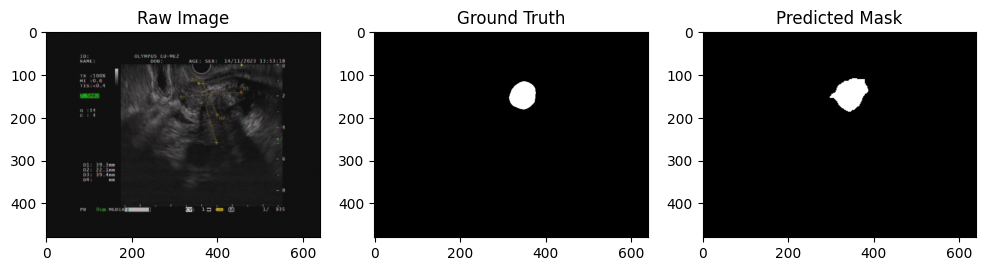

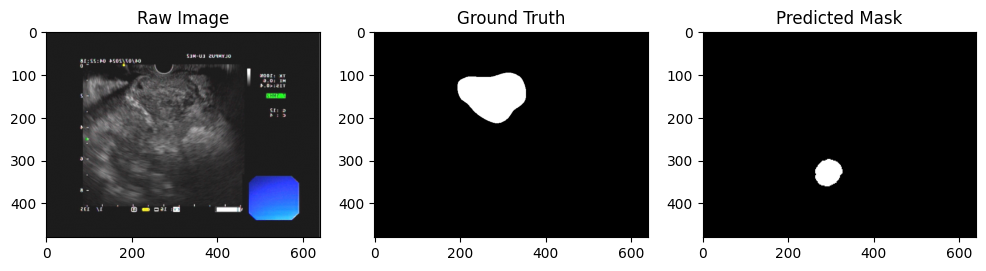

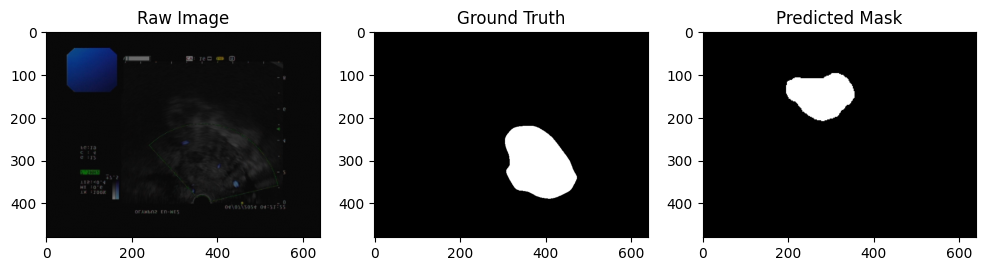

In [9]:
for i in range(3):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(test_generator[i][0][0])
    plt.title('Raw Image')
    plt.subplot(1, 3, 2)
    plt.imshow(test_generator[i][1][0].squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(1, 3, 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.show()